# COMP_SCI_7318 - Assignment 2 - Image Classification on Fashion-MNIST using Convolutional Neural Networks

## Walter Rowlands - a1867404

### Trimester 3, 2022

### Import libraries

For this assignment, the following packages were implemented as shown below.

In [1]:
### Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models
from torchsummary import summary
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Load dataset

The dataset chosen for this assignment was the Fashion-MNIST dataset. Fashion-MNIST is a dataset consisting of 28x28 grayscale images of 70,000 fashion products from 10 categories (as described here: https://paperswithcode.com/dataset/fashion-mnist). The categories are evenly represented in the dataset, so there are 7,000 images for each category. The training set comprises 60,000 images and the test set contains 10,000 images.

Fashion-MNIST can be directly loaded into the workspace from the PyTorch library. The training and test datasets can be called separately simply by modifying the True/False input to the 'train' flag as demonstrated below.

In [2]:
### Download training and test data from PyTorch datasets and initialise as Tensors 
training_data = datasets.FashionMNIST(root = "data", train = True, download = True, transform = ToTensor(),)
test_data = datasets.FashionMNIST(root = "data", train = False, download = True, transform = ToTensor(),)

### Data exploration and preprocessing

Below, we explore the nature of the Fashion-MNIST dataset. 

We first confirm the size of the training and test datasets. Then, we make use of the PyTorch DataLoader. This utility combines a dataset and a sampler, then provides an iterable over a given dataset. This feature supports automatic batching for the images. The batch size specified determines the number of features and labels per Tensor.

Once entered into the DataLoader, we print information about X (features) and y (label) to understand our data dimensions and typing.

Subsequently, we visualise some of the images to understand the dataset at hand.

In [3]:
### Confirm size of training and test datasets
print("Number of training images:", len(training_data))
print("Number of test images:", len(test_data))

Number of training images: 60000
Number of test images: 10000


In [4]:
### Initialise data loaders
batch_size = 32 # EDIT BATCH SIZE FOR MODEL EXPERIMENTS HERE!

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

### Verify dimensions of features and labels
for X, y in test_dataloader:
    print("Shape of X [No. images, Depth, Height, Width]:", X.shape)
    print("Shape of y [Label]:", y.shape, y.dtype) # A label for image each, represented as an integer class
    break

Shape of X [No. images, Depth, Height, Width]: torch.Size([32, 1, 28, 28])
Shape of y [Label]: torch.Size([32]) torch.int64


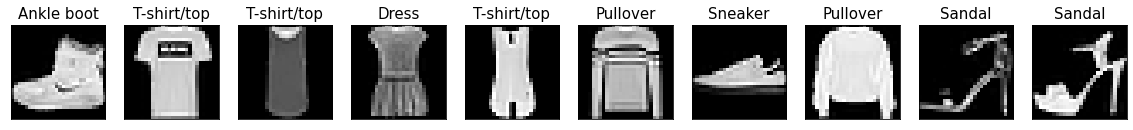

In [5]:
### Visualise some images from the training set
n_samples = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
images, labels = next(iter(train_dataloader))

fig = plt.figure(figsize=(20,5),facecolor='w')
for i in range(n_samples):
    ax = plt.subplot(1, n_samples, i+1)
    plt.imshow(images[i, 0, :, :], vmin = 0, vmax = 1.0, cmap = cm.gray)
    ax.set_title("{}".format(class_names[labels[i]]), fontsize = 15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Prior to beginning work with the Convolutional Neural Network (CNN) models, we will attempt to shift the device to run on high-powered GPU(s) to accelerate training and inference. If GPU is unavailable, the machine will just run on available CPU(s).

In [6]:
### Attempt to access GPU if available, otherwise utilise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


### Model construction and experimentation
The CNN model is implemented using a Python class below. The class implements a function that includes inputs to the convolutional layers and fully connected layers applied in experimentation (this is where layer structure and kernel size edits were made). A subsequent function is used to perform the forward pass through the network.

**Please note:** Not all the experiments and their results are shown below. The experiments were conducted iteratively. After a test was conducted, the performance metrics were tabulated (as seen in the associated report), then model parameters were tuned to conduct the next test.

In [7]:
### Define Convolutional Neural Network model structure!
class CNN(nn.Module):
    def __init__(self): # EDIT CONV LAYER INPUTS AND STRUCTURE BELOW!
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 5)
        
        self.fc1 = nn.Linear(in_features = 24*4*4, out_features = 240)
        self.fc2 = nn.Linear(in_features = 240, out_features = 120)
        self.out = nn.Linear(in_features = 120, out_features = 10)
        
    def forward(self, x): # EDIT POOLING INPUTS AND ACTIVATION FUNCTIONS BELOW!
        
        # hidden layer 1
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        
        # hidden layer 2
        x = self.conv2(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        
        # hidden layer 3
        x = x.reshape(-1, 24*4*4)
        x = self.fc1(x)
        x = torch.tanh(x)
        
        # hidden layer 4
        x = self.fc2(x)
        x = torch.tanh(x)
        
        # output layer
        x = self.out(x)
        
        return x
    
model = CNN().to(device)
summary(model, (1, 28, 28))

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # Code check total trainable params

print("\nTotal model parameters:", pytorch_total_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 24, 24]             312
            Conv2d-2             [-1, 24, 8, 8]           7,224
            Linear-3                  [-1, 240]          92,400
            Linear-4                  [-1, 120]          28,920
            Linear-5                   [-1, 10]           1,210
Total params: 130,066
Trainable params: 130,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.50
Estimated Total Size (MB): 0.57
----------------------------------------------------------------

Total model parameters: 130066


In [8]:
### Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1) # EDIT LEARNING RATE FOR MODEL EXPERIMENTS HERE!

In [9]:
### Initialise lists for plot outputs
train_losses = []
test_losses = []

In [10]:
### Define function for training models
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_losses.append(float(loss)) # Added to compile training loss values after each epoch for plots

In [11]:
### Define a functions for model testing
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_losses.append(test_loss) # Added to compile test loss values after each epoch for plots

In [12]:
### Train and test the model with verbose outputs!
epochs = 10 # EDIT NUMBER OF EPOCHS FOR MODEL EXPERIMENTS HERE!
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Training and predictions complete!")

Epoch 1
-------------------------------
loss: 2.320147  [    0/60000]
loss: 1.133014  [ 3200/60000]
loss: 0.584711  [ 6400/60000]
loss: 0.901226  [ 9600/60000]
loss: 0.503363  [12800/60000]
loss: 0.979816  [16000/60000]
loss: 0.458908  [19200/60000]
loss: 0.338756  [22400/60000]
loss: 0.422700  [25600/60000]
loss: 0.753723  [28800/60000]
loss: 0.667813  [32000/60000]
loss: 0.600493  [35200/60000]
loss: 0.481354  [38400/60000]
loss: 0.576531  [41600/60000]
loss: 0.687198  [44800/60000]
loss: 0.427080  [48000/60000]
loss: 0.515433  [51200/60000]
loss: 0.649053  [54400/60000]
loss: 0.394529  [57600/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.412461 

Epoch 2
-------------------------------
loss: 0.353966  [    0/60000]
loss: 0.506779  [ 3200/60000]
loss: 0.246426  [ 6400/60000]
loss: 0.596407  [ 9600/60000]
loss: 0.263064  [12800/60000]
loss: 0.686744  [16000/60000]
loss: 0.305117  [19200/60000]
loss: 0.215841  [22400/60000]
loss: 0.283271  [25600/60000]
loss: 0.417561  [28800/60000

### Performance evaluation
The performance of the CNN models is evaluated below. First, we plot the training and test losses to visualise model performance during both phases.

A confusion matrix is then generated for the model to provide a visual report that describes 'how' our model is predicting outcomes with respect to each of the 10 classes. We view the confusion matrix for both the training and test dataset to understand how the model is distinctly performing in training, and then how that influences prediction success for different classes.

We then call  functions from the Sklearn library to calculate model accuracy and F1 score.

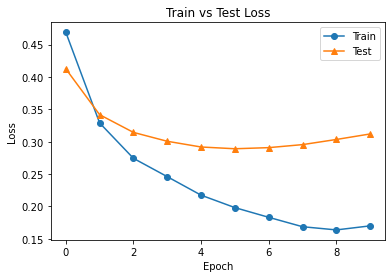

In [13]:
### Plot training and test loss curves
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.title('Train vs Test Loss') # EDIT PLOT TITLES FOR DIFFERENT EXPERIMENTS HERE
plt.savefig('Train vs Test Loss curves', bbox_inches = 'tight', dpi = 200)

In [14]:
### Define function to grab results, and another to tabulate confusion matrix for the multiple classes
### Function to grab predictions
def grab_predictions(model, loader): 
    preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
        
    return preds

### Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, classes, normalize = True, title = None, cmap = None):
    
    cm = confusion_matrix(y_true, y_pred) # Compute confusion matrix
    
    # Option to generate normalised confusion matrix (0-1)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Generate plot
    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = classes, yticklabels=classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

    # Loop over data dimensions and generate text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha = "center", va = "center", color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

np.set_printoptions(precision=2)

Training data performance

Accuracy: 0.932
F1 Score: 0.93


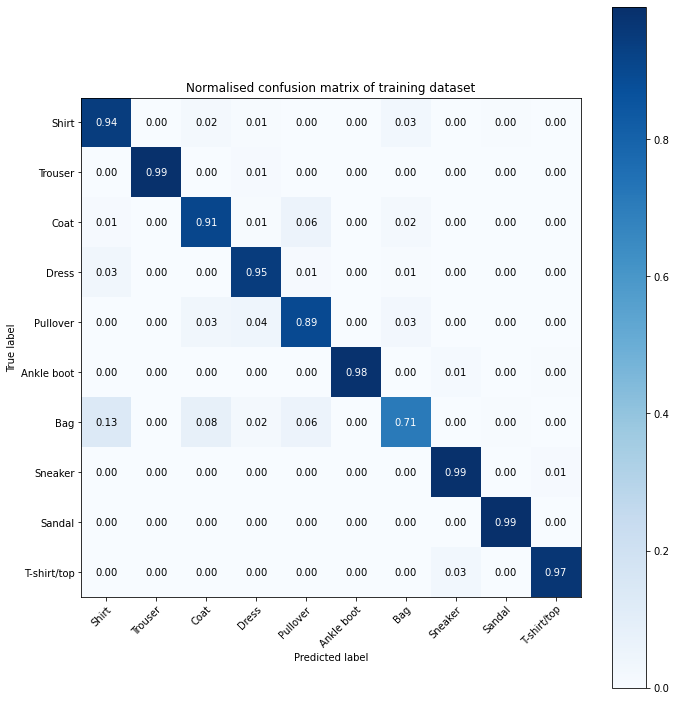

In [15]:
### Generate training data confusion matrix
label_dict = {
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot',
}

title1 = 'Normalised confusion matrix of training dataset'
title2 = 'Normalised confusion matrix of test dataset'
cmap1 = plt.cm.Blues
cmap2 = plt.cm.Greens

training_preds = grab_predictions(model, train_dataloader)

plot_confusion_matrix(training_data.targets, training_preds.argmax(dim=1), classes=label_dict, title=title1, cmap=cmap1)
plt.savefig('Training confusion matrix.jpg', bbox_inches = 'tight', dpi = 200)

print("Training data performance\n")
print('Accuracy:', round(accuracy_score(training_data.targets, training_preds.argmax(dim=1)),3))
print('F1 Score:', round(f1_score(training_data.targets, training_preds.argmax(dim=1), average='weighted'),3))

Test data performance

Accuracy: 0.897
F1 Score: 0.896


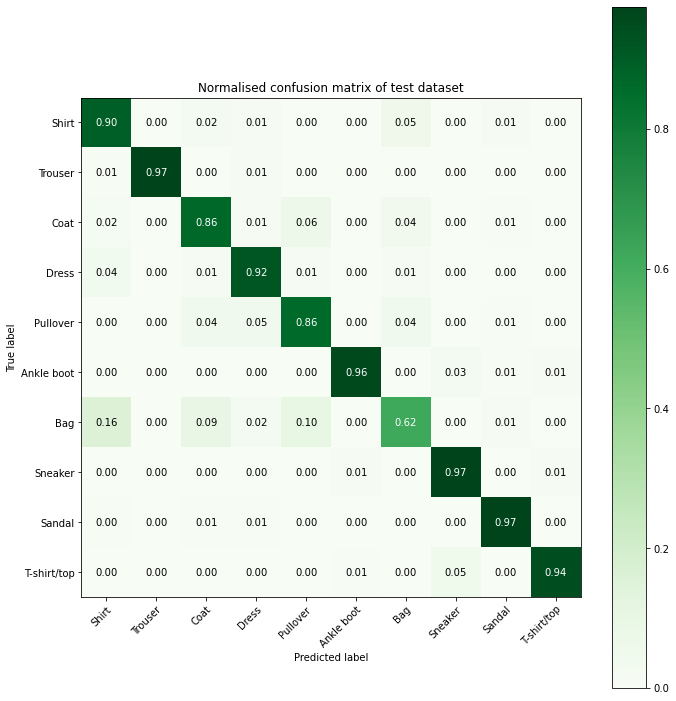

In [16]:
### Generate test data confusion matrix
test_preds = grab_predictions(model, test_dataloader)

plot_confusion_matrix(test_data.targets, test_preds.argmax(dim=1), classes=label_dict, title=title2, cmap=cmap2)
plt.savefig('Testing confusion matrix.jpg', bbox_inches = 'tight', dpi = 200)

print("Test data performance\n")
print('Accuracy:', round(accuracy_score(test_data.targets, test_preds.argmax(dim=1)),3))
print('F1 Score:', round(f1_score(test_data.targets, test_preds.argmax(dim=1), average='weighted'),3))